# Transfer Learning on LFW Dataset (Grayscale)

## Index
1. Introduction
2. Load and Explore the LFW Dataset
3. Data Preparation (Train/Validation Split)
4. Custom Dataset and Transformations
5. DataLoaders
6. Visualizing Sample Images
7. Using Transfer Learning with ResNet18 (Modified for Grayscale)
8. Training the Final Layer
9. Evaluating the Model (Confusion Matrix & Classification Report)
10. Creating a Prediction Widget
11. Visualizing Model Architecture, Filters, and Feature Maps

---

## 1. Introduction
In this notebook, we use a pre-trained ResNet18 model and adapt it to the grayscale LFW dataset by replicating the single channel three times. We freeze all layers except the last layer, which we retrain for our classes. After training, we evaluate using a confusion matrix and a classification report, then create a widget to upload an image and predict its class.
Finally, we will visualize the ResNet model, show filters from the first convolutional layer (`model.conv1`), show filters and feature maps from a layer in `model.layer1` or `model.layer2`, and also examine the final `fc` layer’s weights.

In this notebook, we apply transfer learning using a pre-trained ResNet18 model and adapt it to the Fashion-MNIST dataset.
Since Fashion-MNIST images are grayscale (1 channel) while ResNet18 was trained on ImageNet (RGB, 3 channels), we convert each image to a pseudo-RGB input by replicating the single channel three times. We also resize images to 224×224 and normalize them using the ImageNet mean and standard deviation.

We first freeze all layers of ResNet18 and train only the final fully connected layer for our 10 classes. Optionally, we can later enable fine-tuning by unfreezing deeper layers to further improve performance.

Finally, we evaluate the model using accuracy, a confusion matrix, and a classification report.

## 2. Load and Explore the LFW Dataset
We load the dataset and print basic info.

In [1]:
import torch
# Torch for tensors.
from torch.utils.data import Dataset, DataLoader
# Dataset and DataLoader for PyTorch.
from PIL import Image
# PIL for image handling.
import torchvision.transforms as T
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, random_split
from sklearn.datasets import fetch_lfw_people
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
# Transforms for resizing, normalizing.
# Import function to fetch LFW dataset.
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)
# Load LFW with min 100 faces per person.
images = lfw_people.images
# images: (n_samples, h, w) grayscale.
labels = lfw_people.target
# labels: integer class indices.
target_names = lfw_people.target_names
# target_names: names of the individuals.
n_classes = len(target_names)
# Count distinct classes.
print("Number of samples:", images.shape[0])
# Print how many samples.
print("Image size:", images.shape[1], "x", images.shape[2])
# Print image dimensions.
print("Number of classes:", n_classes)
# Print how many classes.
print("Classes:", target_names)
# Print class names.

Number of samples: 1140
Image size: 50 x 37
Number of classes: 5
Classes: ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


1. Setup and Data Preparation

In [2]:
from torchvision.datasets import FashionMNIST

train_raw = FashionMNIST(root="./data", train=True, download=True)
test_raw  = FashionMNIST(root="./data", train=False, download=True)

print("Train samples:", len(train_raw))
print("Test samples:", len(test_raw))

img0, label0 = train_raw[0]
print("Original image type:", type(img0))
print("Original image size:", img0.size)  # (W, H) = (28, 28)
print("Example label:", label0)

class_names = train_raw.classes
print("Number of classes:", len(class_names))
print("Classes:", class_names)


Train samples: 60000
Test samples: 10000
Original image type: <class 'PIL.Image.Image'>
Original image size: (28, 28)
Example label: 9
Number of classes: 10
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## 3. Data Preparation (Train/Validation Split)
Split the dataset into 80% training and 20% validation.

In [3]:
from torchvision import transforms

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Lambda(lambda x: x.convert("RGB")),  # grayscale → 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])


In [4]:
from torchvision.datasets import FashionMNIST
from torch.utils.data import random_split
import torch

train_full = FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)

train_size = int(0.8 * len(train_full))
val_size   = len(train_full) - train_size

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(
    train_full,
    [train_size, val_size],
    generator=generator
)

val_dataset.dataset.transform = test_transform

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))


Train size: 48000
Validation size: 12000


## 4. Custom Dataset and Transformations
We must replicate the grayscale channel to create a pseudo-3-channel image for ResNet. The model expects 3 channels, so we simply copy the single channel into all three. We then apply standard ImageNet normalization.

In [5]:
class LFWDataset3ChannelGray(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        img = (img * 255).astype(np.uint8)
        img_pil = Image.fromarray(img)
        img_pil_rgb = img_pil.convert('RGB')
        if self.transform:
            img_tensor = self.transform(img_pil_rgb)
        else:
            img_np = np.array(img_pil_rgb).transpose((2,0,1))/255.
            img_tensor = torch.from_numpy(img_np).float()
        return img_tensor, label

In [6]:
from torchvision import transforms

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=3),  # grayscale -> 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])


In [7]:
from torchvision.datasets import FashionMNIST

tmp_ds = FashionMNIST(root="./data", train=True, download=True, transform=train_transform)
x, y = tmp_ds[0]
print("Transformed shape:", x.shape)  
print("Label:", y)


Transformed shape: torch.Size([3, 224, 224])
Label: 9


## 5. DataLoaders
Define a transform for ResNet18: resize to 224x224 and apply ImageNet normalization. Then create training and validation loaders.

In [8]:
from torchvision.datasets import FashionMNIST

test_dataset = FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=test_transform   
)


In [9]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))

# Sanity check
images, labels = next(iter(train_loader))
print("Batch image shape:", images.shape)  
print("Batch labels shape:", labels.shape)  

Train batches: 750
Val batches: 188
Test batches: 157
Batch image shape: torch.Size([64, 3, 224, 224])
Batch labels shape: torch.Size([64])


In [10]:
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, random_split
import torch

train_full = FashionMNIST(root="./data", train=True, download=True, transform=train_transform)
test_dataset = FashionMNIST(root="./data", train=False, download=True, transform=test_transform)

target_names = train_full.classes

train_size = int(0.8 * len(train_full))
val_size   = len(train_full) - train_size
g = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(train_full, [train_size, val_size], generator=g)

val_dataset.dataset.transform = test_transform

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))

images, labels = next(iter(train_loader))
print("Batch image shape:", images.shape)  # [B, 3, 224, 224]
print("Batch labels shape:", labels.shape) # [B]
print("Labels min/max:", labels.min().item(), labels.max().item())
print("len(target_names):", len(target_names))


Train batches: 750
Val batches: 188
Test batches: 157


C:\Users\liory\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch image shape: torch.Size([64, 3, 224, 224])
Batch labels shape: torch.Size([64])
Labels min/max: 0 9
len(target_names): 10


## 6. Visualizing Sample Images
We visualize some images after transformation (and we define an inverse normalization to see them in a more natural color).

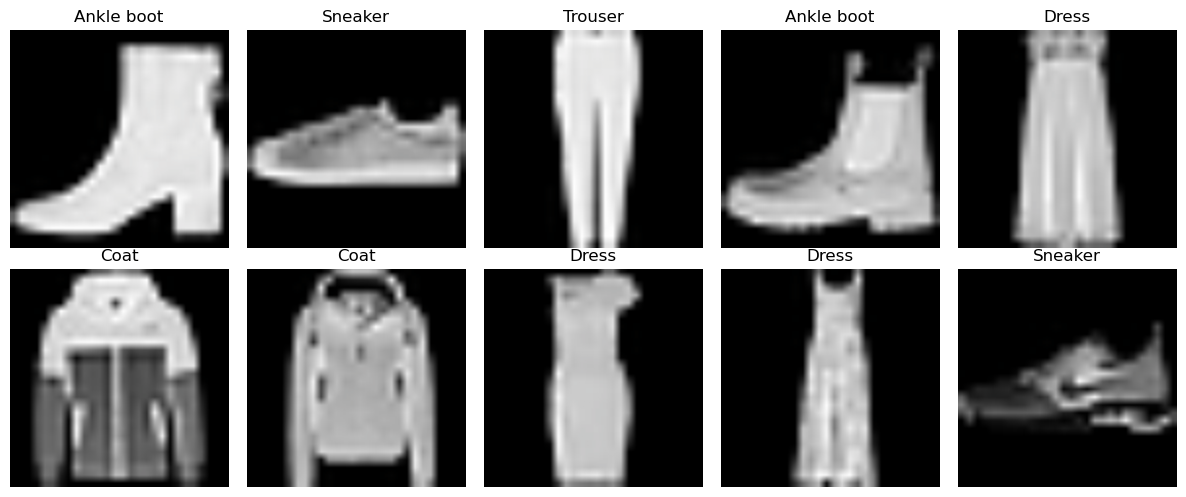

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T

images_batch, labels_batch = next(iter(train_loader))

inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    img = inv_normalize(images_batch[i].cpu()).numpy()
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)

    label_idx = labels_batch[i].item()
    axes[i].imshow(img)
    axes[i].set_title(target_names[label_idx])  # use dataset class names
    axes[i].axis("off")

plt.tight_layout()
plt.show()


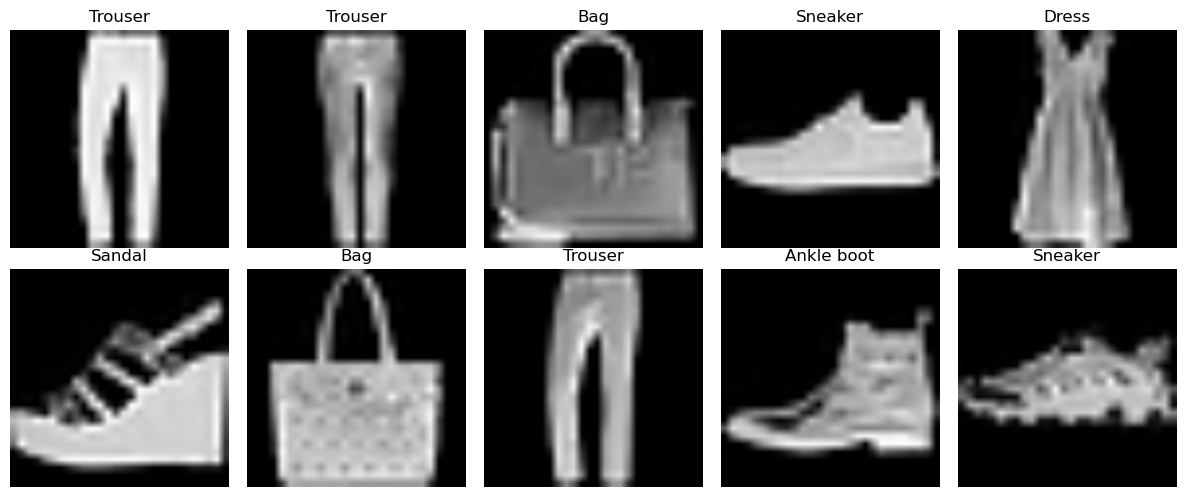

In [12]:
images_batch, labels_batch = next(iter(train_loader))

inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    img = inv_normalize(images_batch[i]).cpu()
    img = img.permute(1, 2, 0).numpy()  # C,H,W -> H,W,C
    img = np.clip(img, 0, 1)

    axes[i].imshow(img)
    axes[i].set_title(class_names[labels_batch[i].item()])
    axes[i].axis("off")

plt.tight_layout()
plt.show()


## 7. Using Transfer Learning with ResNet18 (Modified for Grayscale)
We load ResNet18 pre-trained on ImageNet. We won't modify its internal layers, but since we provide three identical grayscale channels, it can still process the data.
We freeze all layers except the final fully connected layer and replace it with a new layer for our number of classes. We will only train this final layer.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_classes = 10

model = resnet18(weights=ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, n_classes)  # this layer is trainable by default

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

print("model.fc out_features:", model.fc.out_features)

x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)

with torch.no_grad():
    out = model(x)

print("labels min/max:", y.min().item(), y.max().item())
print("Output shape:", out.shape)  


model.fc out_features: 10
labels min/max: 0 9
Output shape: torch.Size([64, 10])


In [14]:
import torch.nn as nn
import torch.optim as optim

n_classes = 10

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, n_classes)
model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

print("model.fc out_features:", model.fc.out_features)


model.fc out_features: 10


In [15]:
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)

with torch.no_grad():
    out = model(x)

print("Output shape:", out.shape)  


Output shape: torch.Size([64, 10])


In [16]:
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)
out = model(x)

print("labels min/max:", y.min().item(), y.max().item())
print("model output shape:", out.shape)
print("model.fc out_features:", model.fc.out_features)


labels min/max: 0 9
model output shape: torch.Size([64, 10])
model.fc out_features: 10


## 8. Training the Final Layer
Train only the last layer for a few epochs.

In [17]:
import torch
import copy
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_targets = []

    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average="macro", zero_division=0
    )

    return (running_loss / total), (correct / total), precision, recall, f1


# Training + Fine-tuning

epochs = 10
fine_tune_start = 3   

best_val_acc = 0.0
best_state = copy.deepcopy(model.state_dict())

history = {
    "train_loss": [], "train_acc": [],
    "val_loss": [], "val_acc": [],
    "val_precision": [], "val_recall": [], "val_f1": []
}

for epoch in range(1, epochs + 1):

    if epoch == fine_tune_start + 1:
        print("\n>> Fine-tuning: unfreezing layer4 and using smaller LR\n")
        for param in model.layer4.parameters():
            param.requires_grad = True
        
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=1e-4
        )

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_precision"].append(val_prec)
    history["val_recall"].append(val_rec)
    history["val_f1"].append(val_f1)

    print(
        f"Epoch {epoch}/{epochs} | "
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f} | "
        f"val_P={val_prec:.4f}, val_R={val_rec:.4f}, val_F1={val_f1:.4f}"
    )

    # Save best by validation accuracy (אפשר גם לפי F1)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = copy.deepcopy(model.state_dict())

print("\nBest validation accuracy:", best_val_acc)

torch.save(best_state, "resnet18_fashionmnist_best.pt")
print("Saved best model to resnet18_fashionmnist_best.pt")


Epoch 1/10 | train_loss=0.6389, train_acc=0.7912 | val_loss=0.4628, val_acc=0.8355 | val_P=0.8353, val_R=0.8361, val_F1=0.8340


  0%|                                                                                          | 0/750 [00:00<?, ?it/s]C:\Users\liory\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/10 | train_loss=0.4381, train_acc=0.8444 | val_loss=0.4178, val_acc=0.8529 | val_P=0.8516, val_R=0.8536, val_F1=0.8510


  0%|                                                                                          | 0/750 [00:00<?, ?it/s]C:\Users\liory\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/10 | train_loss=0.4077, train_acc=0.8551 | val_loss=0.4097, val_acc=0.8505 | val_P=0.8508, val_R=0.8507, val_F1=0.8481

>> Fine-tuning: unfreezing layer4 and using smaller LR



  0%|                                                                                          | 0/750 [00:00<?, ?it/s]C:\Users\liory\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 4/10 | train_loss=0.2748, train_acc=0.9015 | val_loss=0.2164, val_acc=0.9223 | val_P=0.9227, val_R=0.9223, val_F1=0.9223


  0%|                                                                                          | 0/750 [00:00<?, ?it/s]C:\Users\liory\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 5/10 | train_loss=0.1356, train_acc=0.9506 | val_loss=0.2269, val_acc=0.9238 | val_P=0.9243, val_R=0.9242, val_F1=0.9238


  0%|                                                                                          | 0/750 [00:00<?, ?it/s]C:\Users\liory\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 6/10 | train_loss=0.0721, train_acc=0.9749 | val_loss=0.2338, val_acc=0.9280 | val_P=0.9277, val_R=0.9283, val_F1=0.9277


  0%|                                                                                          | 0/750 [00:00<?, ?it/s]C:\Users\liory\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 7/10 | train_loss=0.0427, train_acc=0.9848 | val_loss=0.2694, val_acc=0.9254 | val_P=0.9254, val_R=0.9261, val_F1=0.9255


  0%|                                                                                          | 0/750 [00:00<?, ?it/s]C:\Users\liory\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 8/10 | train_loss=0.0284, train_acc=0.9902 | val_loss=0.3105, val_acc=0.9237 | val_P=0.9258, val_R=0.9238, val_F1=0.9239


  0%|                                                                                          | 0/750 [00:00<?, ?it/s]C:\Users\liory\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 9/10 | train_loss=0.0264, train_acc=0.9906 | val_loss=0.3213, val_acc=0.9247 | val_P=0.9260, val_R=0.9250, val_F1=0.9250


  0%|                                                                                          | 0/750 [00:00<?, ?it/s]C:\Users\liory\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                                                                                                                       

Epoch 10/10 | train_loss=0.0203, train_acc=0.9934 | val_loss=0.3490, val_acc=0.9256 | val_P=0.9254, val_R=0.9259, val_F1=0.9252

Best validation accuracy: 0.928
Saved best model to resnet18_fashionmnist_best.pt


In [18]:
from tqdm import tqdm
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        
        logits = model(x)
        loss = criterion(logits, y)
        
        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    
    return running_loss / total, correct / total


In [21]:
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion
    )

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{epochs} | "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = copy.deepcopy(model.state_dict())


Epoch 1/5 | train_loss=0.0175, train_acc=0.9938 | val_loss=0.3357, val_acc=0.9292


Epoch 2/5 | train_loss=0.0182, train_acc=0.9935 | val_loss=0.3456, val_acc=0.9292


Epoch 3/5 | train_loss=0.0125, train_acc=0.9958 | val_loss=0.3401, val_acc=0.9306


Epoch 4/5 | train_loss=0.0139, train_acc=0.9952 | val_loss=0.3446, val_acc=0.9315


Epoch 5/5 | train_loss=0.0130, train_acc=0.9956 | val_loss=0.4054, val_acc=0.9249


In [30]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import torch

@torch.no_grad()
def evaluate_with_f1(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_targets = []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    _, _, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average="macro", zero_division=0
    )

    return running_loss / total, correct / total, f1


## 9. Evaluating the Model (Confusion Matrix & Classification Report)
Evaluate on the validation set and print performance metrics.

C:\Users\liory\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification Report (TEST):
              precision    recall  f1-score   support

 T-shirt/top     0.8605    0.8820    0.8711      1000
     Trouser     0.9940    0.9870    0.9905      1000
    Pullover     0.8829    0.9050    0.8938      1000
       Dress     0.9084    0.9420    0.9249      1000
        Coat     0.8871    0.8960    0.8915      1000
      Sandal     0.9919    0.9820    0.9869      1000
       Shirt     0.8028    0.7370    0.7685      1000
     Sneaker     0.9625    0.9760    0.9692      1000
         Bag     0.9930    0.9860    0.9895      1000
  Ankle boot     0.9729    0.9680    0.9704      1000

    accuracy                         0.9261     10000
   macro avg     0.9256    0.9261    0.9256     10000
weighted avg     0.9256    0.9261    0.9256     10000



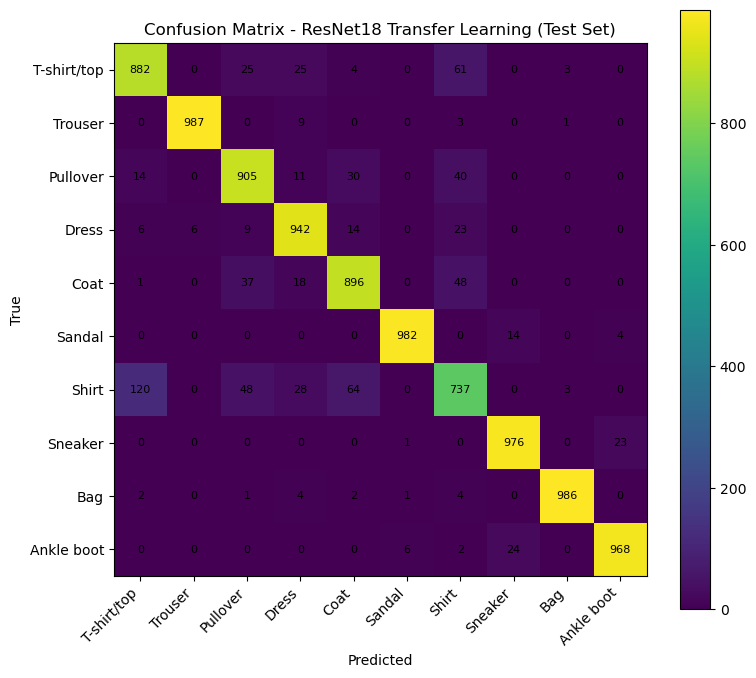

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1) Load best model weights
best_path = "resnet18_fashionmnist_best.pt"
model.load_state_dict(torch.load(best_path, map_location=device))
model.to(device)
model.eval()

# 2) Collect predictions on TEST set
y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:   # <-- test set evaluation
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1).cpu().numpy()

        y_true.extend(y.numpy())
        y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Class names (better: use target_names from dataset if you have it)
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# 3) Classification report
print("Classification Report (TEST):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# 4) Confusion Matrix (plot)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 7))
plt.imshow(cm)
plt.title("Confusion Matrix - ResNet18 Transfer Learning (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()

plt.xticks(range(10), class_names, rotation=45, ha="right")
plt.yticks(range(10), class_names)

# Add numbers in each cell (optional but nice)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()


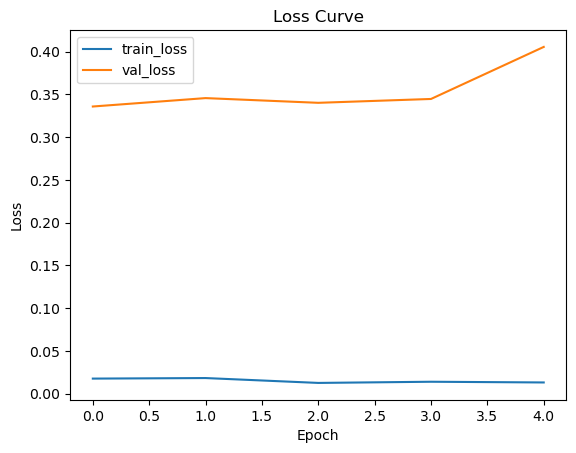

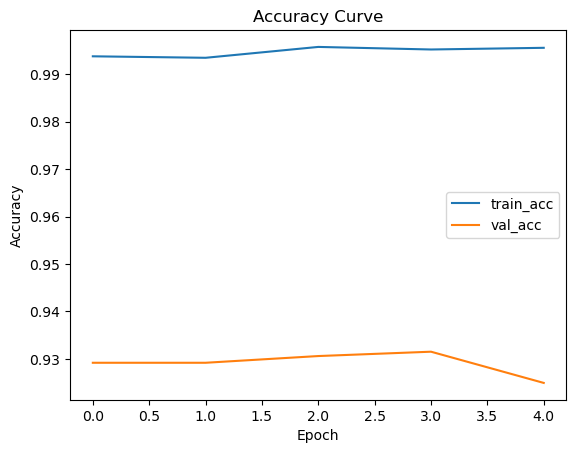

In [32]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [33]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


              precision    recall  f1-score   support

 T-shirt/top     0.8605    0.8820    0.8711      1000
     Trouser     0.9940    0.9870    0.9905      1000
    Pullover     0.8829    0.9050    0.8938      1000
       Dress     0.9084    0.9420    0.9249      1000
        Coat     0.8871    0.8960    0.8915      1000
      Sandal     0.9919    0.9820    0.9869      1000
       Shirt     0.8028    0.7370    0.7685      1000
     Sneaker     0.9625    0.9760    0.9692      1000
         Bag     0.9930    0.9860    0.9895      1000
  Ankle boot     0.9729    0.9680    0.9704      1000

    accuracy                         0.9261     10000
   macro avg     0.9256    0.9261    0.9256     10000
weighted avg     0.9256    0.9261    0.9256     10000



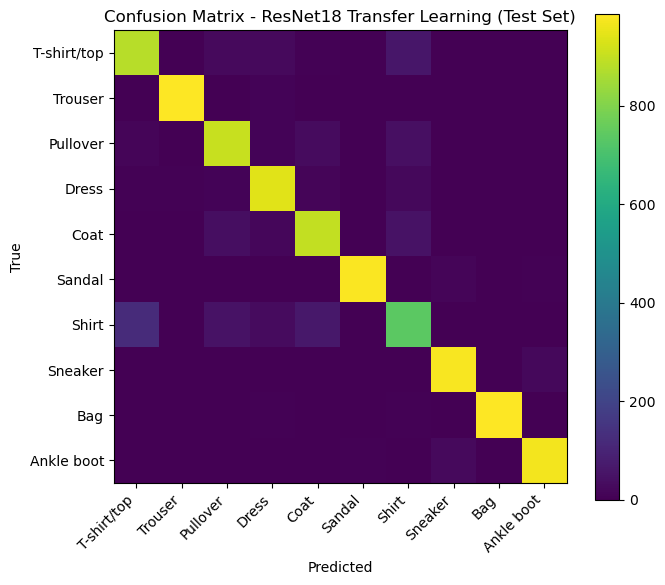

In [34]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
plt.imshow(cm)
plt.title("Confusion Matrix - ResNet18 Transfer Learning (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks(range(10), class_names, rotation=45, ha="right")
plt.yticks(range(10), class_names)
plt.tight_layout()
plt.show()


## 10. Creating a Prediction Widget
We now add a widget to allow image upload and prediction. We'll replicate the single channel into three channels and use the ResNet transform to predict.

In [35]:
import io
import torch
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

def predict_pil_image(model, pil_img, transform, device):
    model.eval()
    with torch.no_grad():
        x = transform(pil_img).unsqueeze(0).to(device)  # [1,3,224,224]
        logits = model(x)
        pred = logits.argmax(dim=1).item()
    return pred

upload = widgets.FileUpload(accept="image/*", multiple=False)
btn = widgets.Button(description="Predict", button_style="success")
out = widgets.Output()

def on_click(_):
    with out:
        clear_output()
        if len(upload.value) == 0:
            print("Please upload an image first.")
            return

        file_info = list(upload.value.values())[0]
        content = file_info["content"]
        pil_img = Image.open(io.BytesIO(content)).convert("RGB")

        pred_idx = predict_pil_image(model, pil_img, test_transform, device)

        display(pil_img)
        print("Predicted class:", class_names[pred_idx])

btn.on_click(on_click)

display(upload, btn, out)


FileUpload(value={}, accept='image/*', description='Upload')

Button(button_style='success', description='Predict', style=ButtonStyle())

Output()

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model_predictions(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            y_true.extend(y.numpy())
            y_pred.extend(preds)
    return np.array(y_true), np.array(y_pred)

def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return acc, prec, rec, f1

# --- ResNet metrics (כבר יש לך y_true, y_pred משלב 9) ---
resnet_acc, resnet_prec, resnet_rec, resnet_f1 = compute_metrics(y_true, y_pred)

print("ResNet18 Transfer Learning:")
print("Acc:", resnet_acc, "Prec:", resnet_prec, "Rec:", resnet_rec, "F1:", resnet_f1)

# --- CNN metrics (כאן תטען את ה-CNN שלך ותחשב) ---
# cnn_model = ...  # טען/הגדר את ה-CNN ממטלה 4
# cnn_model.load_state_dict(torch.load("cnn_best.pt", map_location=device))
# cnn_model = cnn_model.to(device)

# y_true_cnn, y_pred_cnn = evaluate_model_predictions(cnn_model, test_loader, device)
# cnn_acc, cnn_prec, cnn_rec, cnn_f1 = compute_metrics(y_true_cnn, y_pred_cnn)

# print("Custom CNN (Exercise 4):")
# print("Acc:", cnn_acc, "Prec:", cnn_prec, "Rec:", cnn_rec, "F1:", cnn_f1)


ResNet18 Transfer Learning:
Acc: 0.9261 Prec: 0.9255981703237822 Rec: 0.9261000000000001 F1: 0.9256384951236087


In [38]:
import pandas as pd

comparison = pd.DataFrame([
    {
        "Model": "ResNet18 TL (Ex5)",
        "Accuracy": resnet_acc,
        "Precision": resnet_prec,
        "Recall": resnet_rec,
        "F1": resnet_f1
    }
])

comparison


,Model,Accuracy,Precision,Recall,F1
0,ResNet18 TL (Ex5),0.9261,0.925598,0.9261,0.925638


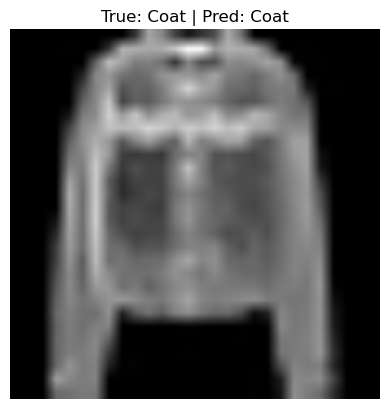

In [40]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms as T

inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

idx = random.randint(0, len(test_dataset)-1)
x, y = test_dataset[idx]

model.eval()
with torch.no_grad():
    logits = model(x.unsqueeze(0).to(device))
    pred = logits.argmax(dim=1).item()

img = inv_normalize(x).permute(1,2,0).cpu().numpy()
img = np.clip(img, 0, 1)

plt.figure()
plt.imshow(img)
plt.title(f"True: {class_names[y]} | Pred: {class_names[pred]}")
plt.axis("off")
plt.show()


In [41]:
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 11. Visualizing Model Architecture, Filters, and Feature Maps
Now we:
- Print the model architecture.
- Visualize the filters from the first conv layer (`model.conv1`).
- Visualize filters and feature maps from a second layer in `model.layer1` (e.g., `model.layer1[0].conv1`).
- Visualize the weights of the final `fc` layer as a grid.

This helps us understand what the pre-trained model looks like and how it has adapted with our last layer.

In [42]:
print(model)
# Print the full ResNet model architecture.

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
import math

def visualize_filters(layer, title="Filters"):
    # This function visualizes the filters of a given convolutional layer.
    with torch.no_grad():
        filters = layer.weight.data.clone()
    # Normalize filters to [0,1].
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    out_channels = filters.shape[0]

    # We want 4 rows, so we determine the number of columns accordingly
    n_rows = 4
    n_columns = math.ceil(out_channels / n_rows)

    fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns*2, n_rows*2))
    fig.suptitle(title)

    # Flatten axs for easy indexing
    axs = axs.flatten()

    for i in range(out_channels):
        f = filters[i].cpu().numpy()
        # f shape: (in_ch, kH, kW), assuming in_ch=1
        f = f[0]
        axs[i].imshow(f, cmap='gray')
        axs[i].axis('off')

    # Hide any unused subplots if out_channels is not a perfect multiple
    for j in range(out_channels, n_rows*n_columns):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


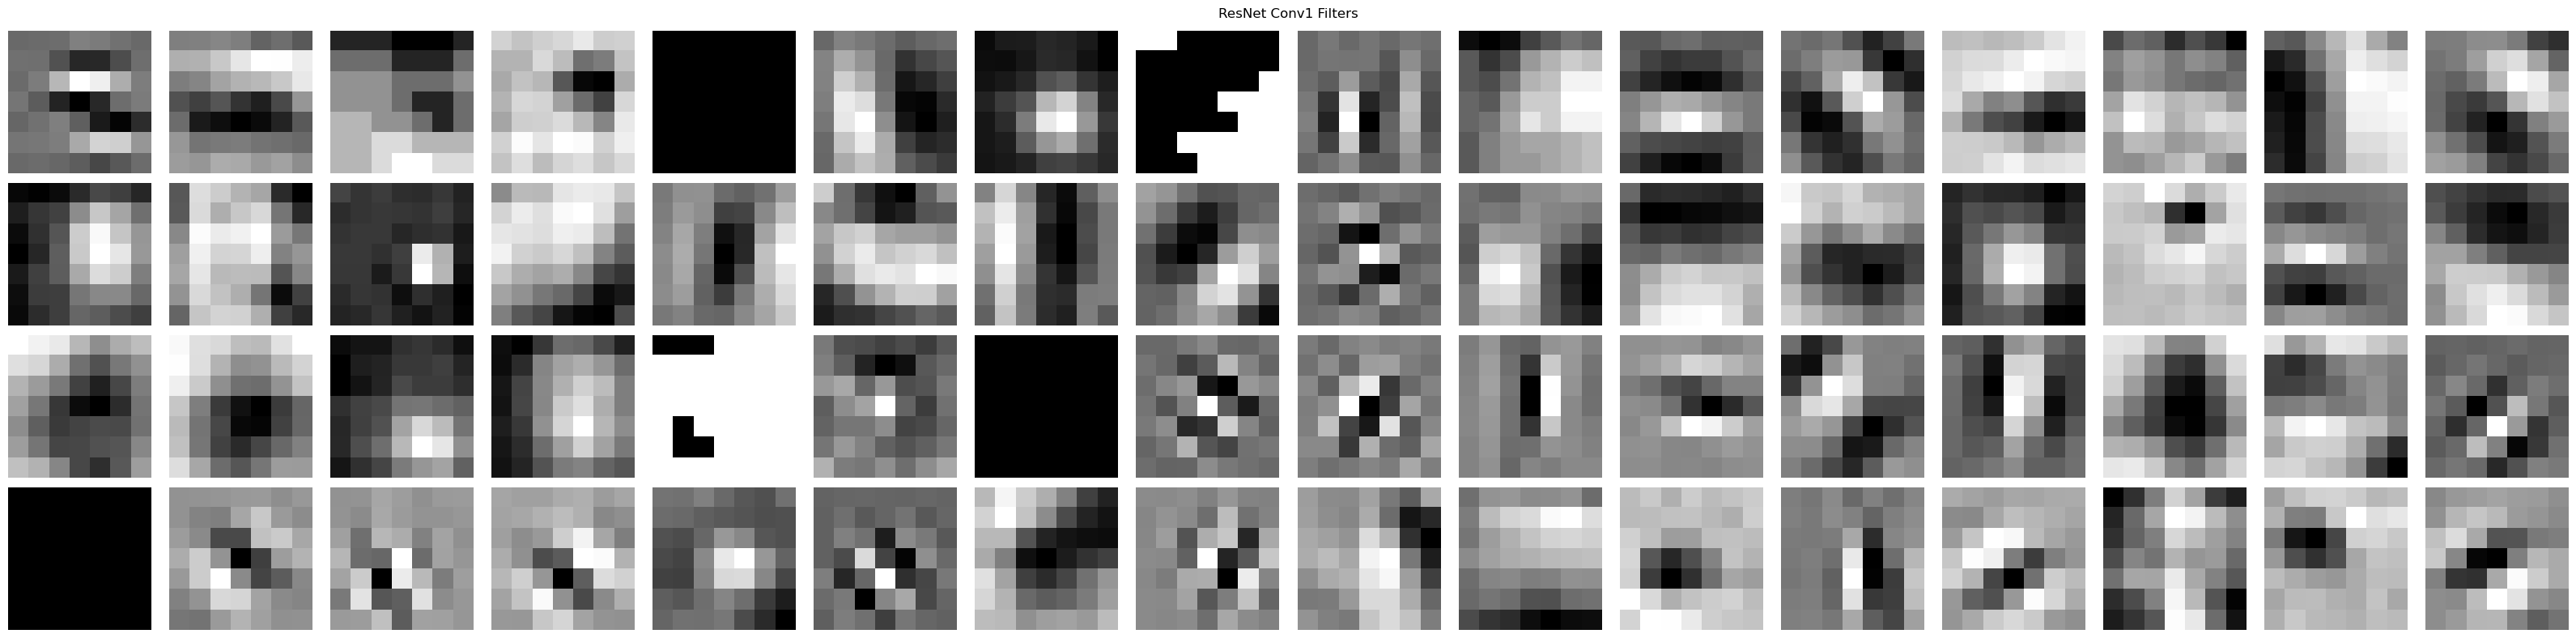

In [44]:
# Visualize filters of the first conv layer of ResNet.
visualize_filters(model.conv1, title="ResNet Conv1 Filters")

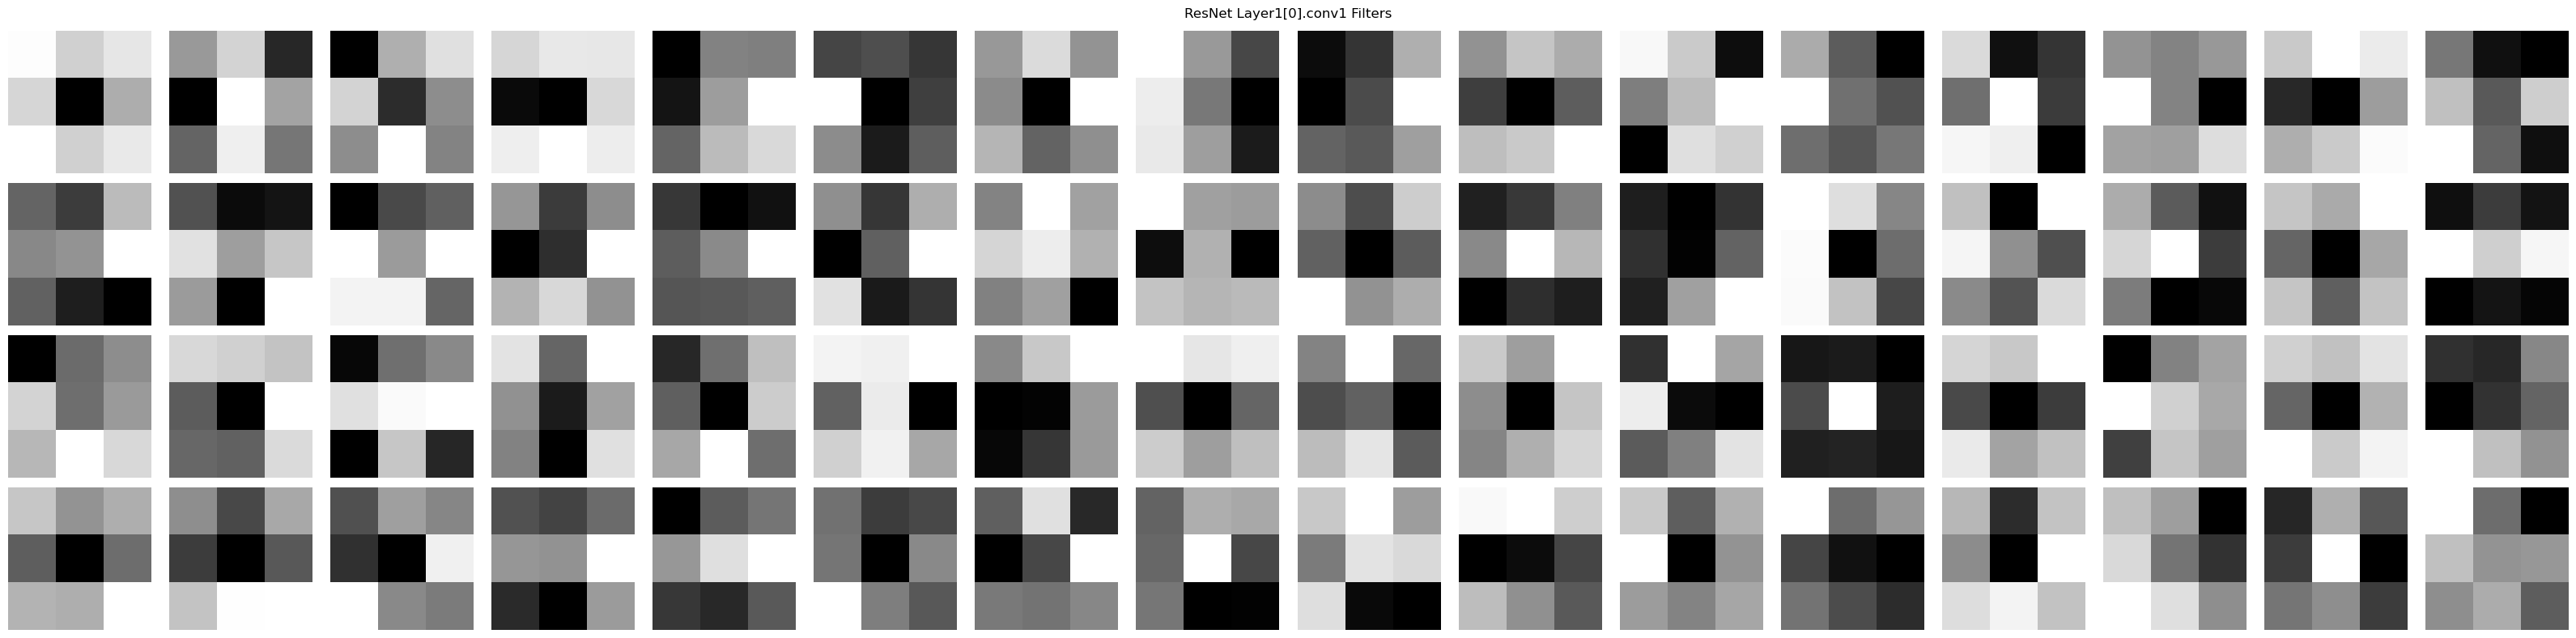

In [45]:
visualize_filters(model.layer1[0].conv1, title="ResNet Layer1[0].conv1 Filters")

In [46]:
import math

def visualize_feature_maps(model, layer_func,  title="Feature Maps"):
    # This function passes one image through the model up to a given layer_func and shows the feature maps.
    # layer_func is a function that takes an input x and returns the output after the desired layer.
    # We also added val_dataset_gray and device as parameters for flexibility.
    model.eval()
    sample_img, _ = val_dataset[0]
    # Take one image from validation set.
    sample_img = sample_img.unsqueeze(0).to(device)
    # Add batch dimension and move to device.
    with torch.no_grad():
        fm = layer_func(sample_img)
        # Get feature maps.
    # Normalize feature maps.
    fm_min, fm_max = fm.min(), fm.max()
    fm = (fm - fm_min) / (fm_max - fm_min)
    fm = fm.squeeze(0).cpu()
    # Shape: (out_ch, H, W)
    out_ch = fm.shape[0]

    # Fixed number of rows
    n_rows = 4
    n_columns = math.ceil(out_ch / n_rows)

    fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns*2, n_rows*2))
    fig.suptitle(title)
    axs = axs.flatten()  # Flatten so we can iterate easily

    for i in range(out_ch):
        f_map = fm[i].numpy()
        axs[i].imshow(f_map, cmap='gray')
        axs[i].axis('off')

    # Hide any unused subplots
    for j in range(out_ch, n_rows*n_columns):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()



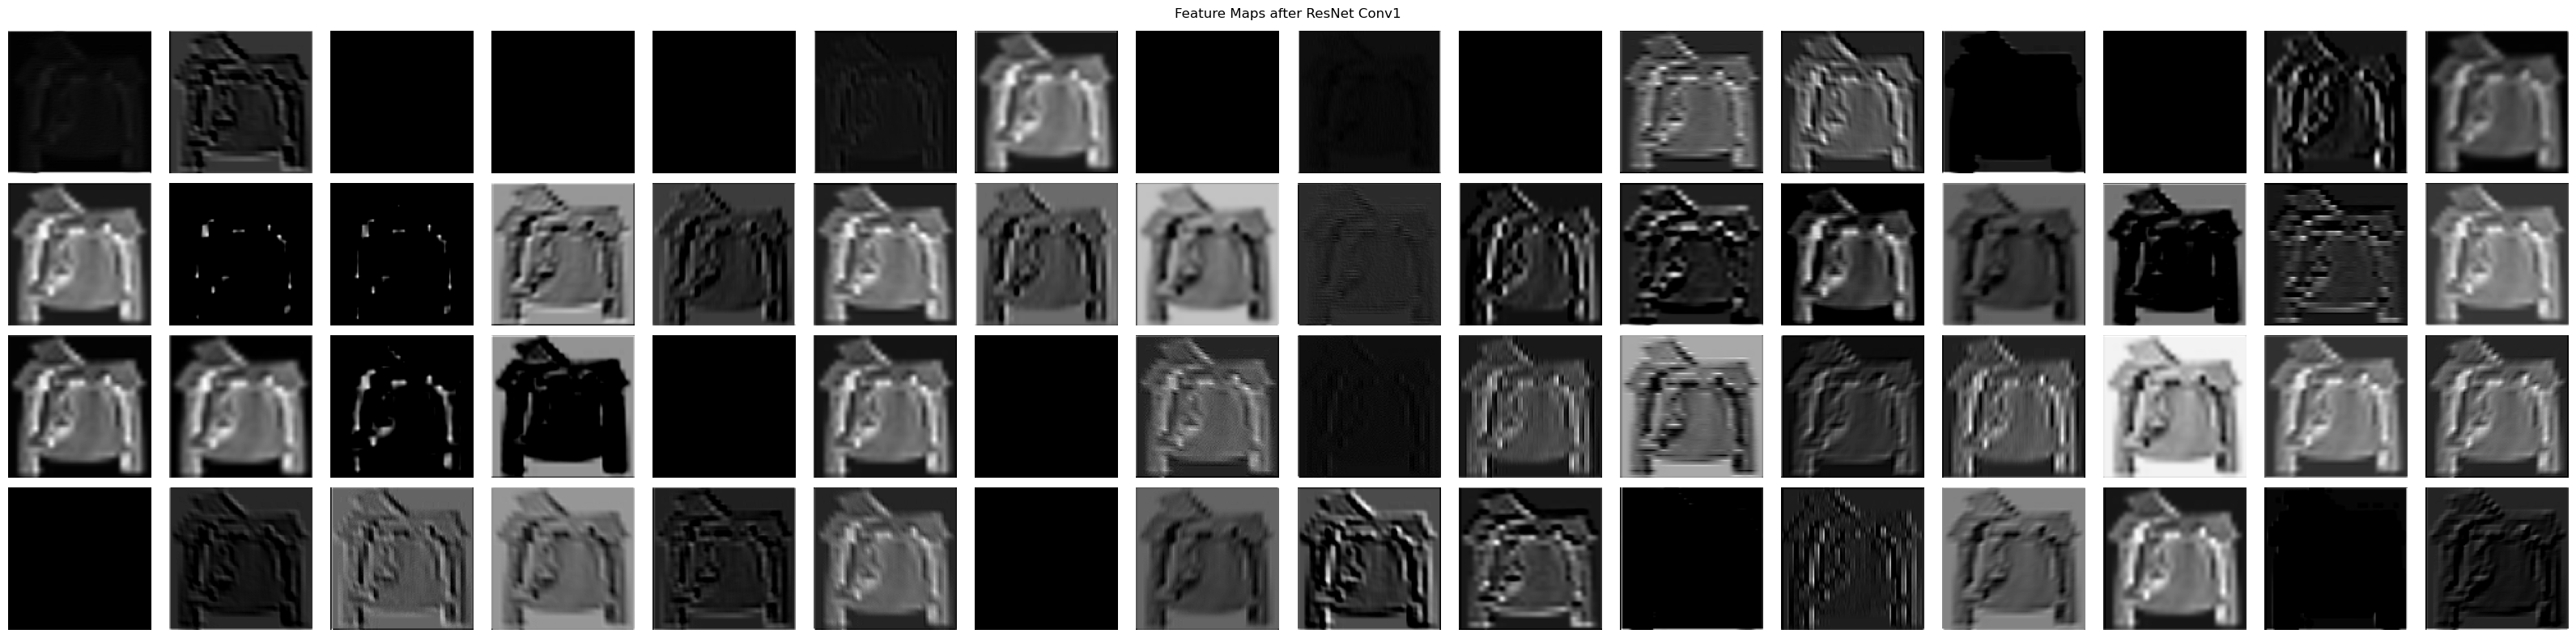

In [47]:
# Define layer_func for conv1 feature maps in ResNet
def conv1_features_resnet(x):
    # Pass x through conv1, bn1, relu, and stop before pool.
    x = model.conv1(x)
    x = model.bn1(x)
    x = torch.relu(x)
    # Not pooling yet, just show after conv1.
    return x

# Visualize feature maps after conv1 in ResNet.
visualize_feature_maps(model, conv1_features_resnet, title="Feature Maps after ResNet Conv1")

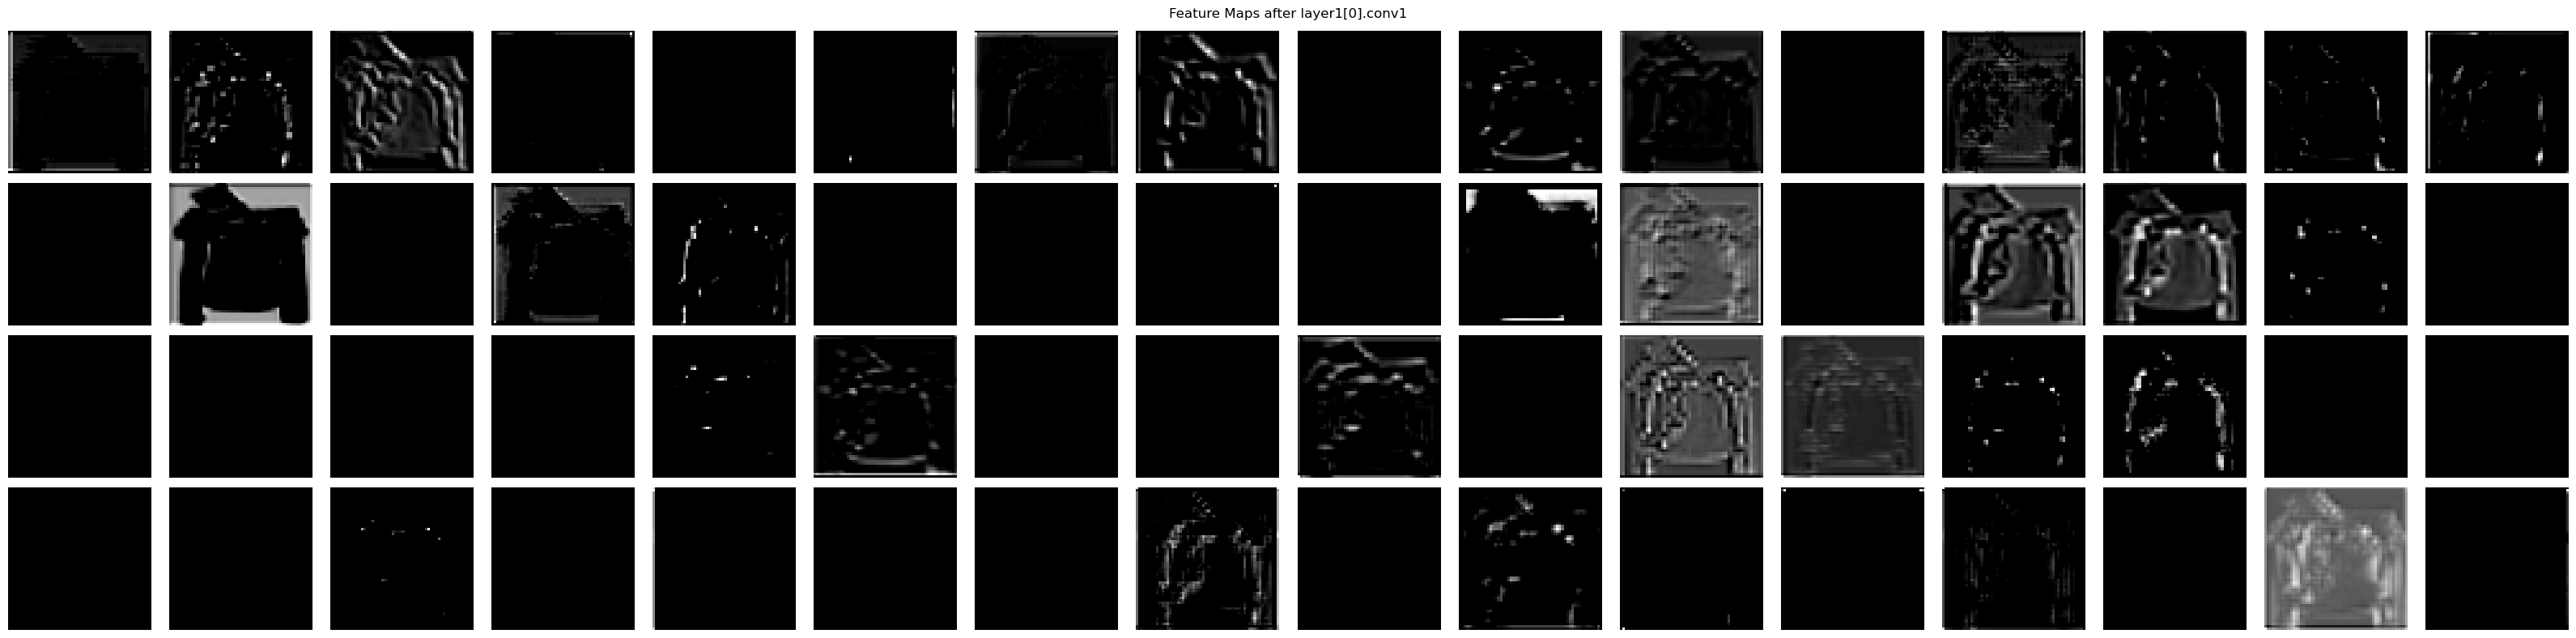

In [48]:
# For the second layer (e.g. model.layer1[0].conv1):
# We need a layer_func that passes data through conv1->bn1->relu->maxpool->layer1[0].conv1 (and its following relu?)
def layer1_conv1_features_resnet(x):
    x = model.conv1(x)
    x = model.bn1(x)
    x = torch.relu(x)
    x = model.maxpool(x)
    # Now pass through layer1[0].conv1 and relu
    x = model.layer1[0].conv1(x)
    x = torch.relu(x)
    return x

visualize_feature_maps(model, layer1_conv1_features_resnet, title="Feature Maps after layer1[0].conv1")